# Anomaly Detection 
In machine learning, anomaly detection is the process of discovering patterns or occurrences in a dataset that differ considerably from the norm or expected behavior. Anomalies, also known as outliers, are data points that are uncommon, rare, or do not follow the general patterns observed in the rest of the data. The goal of anomaly detection algorithms is to discover these irregularities automatically. Anomaly detection in machine learning offers a wide range of applications, including predictive maintenance and healthcare monitoring. These algorithms aid in the detection of potential threats by automatically identifying irregularities.

To improve the givin code, we now provide a view option.
I choose to increase data quality for anomaly detection in time series data so that we can concentrate on reducing outliers caused by sensor reading problems while preserving abnormalities. Furthermore, resampling or aggregation can assist minimize noise and emphasize higher-level patterns important for anomaly identification. Find and apply common actions to improve data quality for this specific usage. Compare the algorithm performance to that of the original notebook.

## The data
source : https://www.kaggle.com/datasets/nphantawee/pump-sensor-data . 

Data is from sensor to detect failures in a pump system

In [1]:
# needed modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import yaml


In [2]:
# load the dataset
with open("config.yml") as config:
    input_files = yaml.safe_load(config)
    df = pd.read_csv(input_files["sensor"]).drop('Unnamed: 0', axis=1)

df



,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,NORMAL
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,NORMAL
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856,NORMAL


In [3]:
# Examine the data properties 
amount_na= {}
# check shape
print(f"columns in the dataframe:{df.shape[1]}. Amount of rows {df.shape[0]}.")
print(df.dtypes)
# check na
for col in df.columns:
    amount_na[col] = (df[col].isna().sum() / df.shape[0]) * 100
sorted_amount_na = sorted(amount_na.items(), key=lambda x:x[1], reverse=True)
print(sorted_amount_na)
print(df["machine_status"].unique(), "<- The groups in the data")

columns in the dataframe:54. Amount of rows 220320.
timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35   

We can see that the data contains a large number of NAN values, with sensor 15 and 50 missing nearly all of them. 

In [4]:
# drop these sensors 
df = df.drop(columns=["sensor_15","sensor_50"])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

I'll try to predict broken status using DBSCAN from sklearn.
Density-Based Spatial Clustering of Applications with Noise is abbreviated as DBSCAN. It is a widely used density-based clustering algorithm in machine learning and data mining. DBSCAN clusters data points that are close together and distinguishes high density from low density zones.
DBSCAN's key advantages are its capacity to handle clusters of any shape, its ability to recognize outliers as noise points, and its resistance to cluster number selection. DBSCAN, on the other hand, can be sensitive to the epsilon parameter, which defines the distance threshold for determining the neighborhood.


In [5]:
# use mean of the column to handle missing values and remove label in feature matrix X
m, n = df.shape
X = df.iloc[:,:n-1] # ignore machine status columns
X = X.fillna(X.mean())
X.shape

(220320, 50)

In [6]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X = scaler.fit_transform(X)


In [7]:
# DBSCAN
scanner = DBSCAN(eps=2)
y_pred = scanner.fit_predict(X)  

In [8]:
df[f'DBSCAN'] = y_pred

In [12]:
df["DBSCAN"].value_counts()

 0      164586
 92      18973
 172      4210
 245      2304
-1        1928
         ...  
 324         5
 2           5
 59          5
 34          5
 286         4
Name: DBSCAN, Length: 362, dtype: int64

In [13]:
broken_rows = df[df['machine_status']=='BROKEN']
recovery_rows = df[df['machine_status']=='RECOVERING']
normal_rows = df[df['machine_status']=='NORMAL']

def plot_sensor_anomolies(sensor, name):
    anomoly_rows = df[df[f'{name}'] == -1]
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(df[sensor], color='grey')
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering',alpha = 0.5)
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=20, label='broken')
    plot = plt.plot(anomoly_rows[sensor], linestyle='none', marker='X', color='grey', markersize=5, label='anomoly predicted', alpha = 1)
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show();


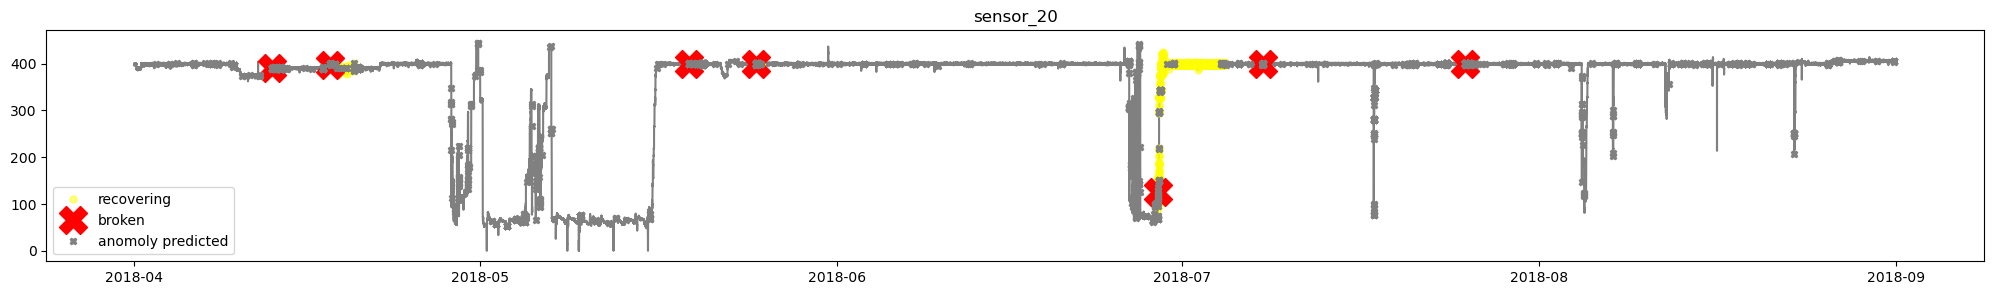

In [14]:
plot_sensor_anomolies('sensor_20', 'DBSCAN')


Just disregard what I stated. In this kind of data, it is not very effective at forecasting the broken condition.
for unexplained causes. The eps could be scaled up, but that would require a lot of processing power.
